# 0. Welcome to exploring continuous seismograms with scatseisnet

Hello! With these notebooks, we want to show how you could use the scatseisnet package for exploring your continuous seismograms for your task at hand. In the following notebooks, we will built a scattering network to calculate the scattering coefficients of a toy dataset. The scattering coefficients are well-adapted to data exploration methods such as dimensionality reduction and clustering methods, which we will also explore. We investigate different exploration methods which have been presented in 
Seydoux et al. [2020](https://www.nature.com/articles/s41467-020-17841-x),
and Steinmann et al. [2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455),
[2022](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL098854),
[2023](https://essopenarchive.org/doi/full/10.22541/essoar.168614505.54607219), and we hope that these notebooks will inspire your research.

Here a summary of what the following notebooks cover:
- **0_intro**: Introduction to the tutorial and the toy dataset and task at hand
- **1_design**: Initiate a scattering network and its parameters
- **2_transformation**: Apply the scattering network to the toy dataset, retrieving the scattering coefficients
- **3_reduction**: Apply PCA and FastICA to the scattering coefficient matrix
- **4_reconstruction**: Investigate the role of mixing weights and reconstruct a part of the scattering coefficients
- **5_clustering**: Perform clustering in the principal component space
- **6_atlas**: Explore the data with a seismogram atlas through UMAP

Made in April 2023 by Léonard Seydoux and René Steinmann.

Updated in November 2023

> **Note**: This notebook requires the installation of the matplotlib and obspy libraries, which are not included in the default installation of the scatseisnet library. To install them, please visit the [matplotlib website](https://matplotlib.org/stable/users/installing.html) and the [obspy wiki](https://github.com/obspy/obspy/wiki#installation).

In [2]:
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime

%config InlineBackend.figure_format = "svg"

## 0.0 Load toy seismogram with volcanic tremor signal

The design of the scattering network and the data exploration method depend on the data and task at hand.
Therefore, we will first define the data and task before diving into the details of scatseisnet.
We choose a one-day-long three-component seismogram from station SV13 from the temporary KISS network, which has been installed in the Klyuchevskoy volcano group in 2015/2016. In our study Steinmann et al.
([2023](https://essopenarchive.org/doi/full/10.22541/essoar.168614505.54607219)), we analyse the whole recording period of SV13.
However, for the tutorials it is more convinient to pick one day.
We pick the 4th of December 2015, which marks the onset of tremor activity due to the reactivation of the Klyuchevskoy volcano.
We download the data from the [GFZ data center](https://geofon.gfz-potsdam.de/).
Note that this can be easily adapted to handle larger and more complex data sets
by simply adjusting the input parameters and increasing the computational
resources. Also consider the other notebooks for adapting the methods to your resources. 
From GFZ, Potsdam, Germany, the following cell takes about 20 seconds to run.

In [4]:
# Connect to the IRIS datacenter
client = Client("GFZ")

# Collect waveforms from the datacenter
stream = client.get_waveforms(
    network="X9",
    station="SV13",
    location="*",
    channel="*",
    starttime=UTCDateTime("2015-12-04T00:00"),
    endtime=UTCDateTime("2015-12-05T00:00"),
)

## 0.1 Pre-processing

It may often be useful to remove the trend, merge potentially non-overlapping
segments, etc. For finding the best processing strategy, depending on the data
at hand, we suggest to have a look at the different [signal processing routines
for ObsPy](https://docs.obspy.org/packages/obspy.signal.html). In the following
cell, we merge together the potentially non-overlapping data segments, detrend
the resulting trace and high-pass filter it above 1 Hz.

You surely need to adapt this cell to your data, and task at hand.

3 Trace(s) in Stream:
X9.SV13..HHE | 2015-12-04T00:00:00.000000Z - 2015-12-05T00:00:00.000000Z | 50.0 Hz, 4320001 samples
X9.SV13..HHN | 2015-12-04T00:00:00.000000Z - 2015-12-05T00:00:00.000000Z | 50.0 Hz, 4320001 samples
X9.SV13..HHZ | 2015-12-04T00:00:00.000000Z - 2015-12-05T00:00:00.000000Z | 50.0 Hz, 4320001 samples


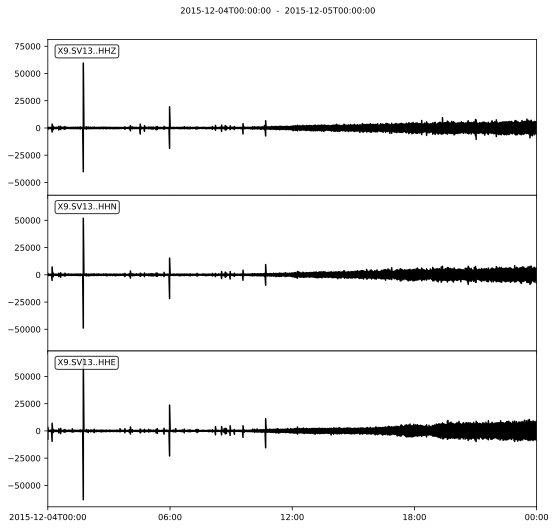

/home/steinre/anaconda3/envs/scatseisnet/lib/python3.10/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [5]:
stream.merge(method=1)
stream.detrend("linear")
stream.filter(type="highpass", freq=1.0)
print(stream)
stream.plot(rasterized=True)

# save the stream data for the other notebooks
stream.write("../example/scattering_stream.mseed", format="MSEED")

## 0.2 Signals in the seismogram and our task for the following notebooks

We see the increasing amplitude of the volcanic tremor and a few transient events in the first half of the day. With scatseisnet we want to explore this one-day long three-component seismogram and identify clusters related to the tremor and non-tremor activity. Note that this is only a toy example. The power of scatseisnet and data exploration lies in exploring large continuous time series when manual investigation is not feasible.